# <a id='toc1_'></a>[Pandasによる時系列データの取り扱い](#toc0_)
面倒な時系列データをPandasで取り扱う方法をメモしておく。  

* 参考： 
  * https://note.nkmk.me/python-pandas-datetime-timestamp/

**Table of contents**<a id='toc0_'></a>    
- [Pandasによる時系列データの取り扱い](#toc1_)    
  - [様々な形式で表現された時刻データの取り扱い](#toc1_1_)    
    - [- 時刻データが標準的なフォーマットの場合](#toc1_1_1_)    
    - [- 数字の羅列になっている場合](#toc1_1_2_)    
    - [- 年月日と時刻が別のカラムの場合](#toc1_1_3_)    
    - [- さらにカラムが分けられているケース](#toc1_1_4_)    
    - [- エポック秒の変換](#toc1_1_5_)    
  - [時刻でgroupbyして統計量を求める](#toc1_2_)    
  - [ナノ秒レベルの時刻同士で2つのテーブルを紐づけ](#toc1_3_)    
  - [任意の時間範囲でフィルタリング](#toc1_4_)    
  - [時刻をx軸としてグラフを描いて軸範囲を操作する](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import time
import random
import os
import math
import itertools
from pathlib import Path
from glob import glob
from sklearn.preprocessing import StandardScaler, LabelEncoder

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## <a id='toc1_1_'></a>[様々な形式で表現された時刻データの取り扱い](#toc0_)
ログの分析などではナノ秒まで情報が必要な場合があるので、  
適宜ナノ秒まで含めて取り扱う。  
年月日がいらないケースでも基本的にdatetimeに変換しておくと便利。

### <a id='toc1_1_1_'></a>[- 時刻データが標準的なフォーマットの場合](#toc0_)
下記のようなデータ形式の場合、データ整形の必要なく変換できる。
* yyyy-mm-dd HH:MM:SS.f
* yyyy/mm/dd HH:MM:SS.f
* yyyy-mm-dd HHMMSS.f  

In [2]:
df = pd.DataFrame({'DateTime_1': 
         ['2020-01-01 16:10:11.123456789',
          '2020-01-01 17:11:22.123456790',
          '2020-01-01 18:12:33.123456791'],
          'DateTime_2': 
         ['2020/01/01 16:10:11.123456789',
          '2020/01/01 17:11:22.123456790',
          '2020/01/01 18:12:33.123456791'],
          'DateTime_3': 
         ['2020/01/01 161011.123456789',
          '2020/01/01 171122.123456790',
          '2020/01/01 181233.123456791'],
          'DateTime_4': 
         ['2020/01/01 161011.123456',
          '2020/01/01 171122.123456790',
          '2020/01/01 181233.123'],
        })

In [3]:
# 各列をdatetime型に変換する
for i, col in enumerate(df.columns):
    df[f'DateTime_{i+1}'] = pd.to_datetime(df[col])

/tmp/ipykernel_25815/393033015.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[f'DateTime_{i+1}'] = pd.to_datetime(df[col])
/tmp/ipykernel_25815/393033015.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[f'DateTime_{i+1}'] = pd.to_datetime(df[col])


In [5]:
df.head(3)

,DateTime_1,DateTime_2,DateTime_3,DateTime_4
0,2020-01-01 16:10:11.123456789,2020-01-01 16:10:11.123456789,2020-01-01 16:10:11.123456789,2020-01-01 16:10:11.123456000
1,2020-01-01 17:11:22.123456790,2020-01-01 17:11:22.123456790,2020-01-01 17:11:22.123456790,2020-01-01 17:11:22.123456790
2,2020-01-01 18:12:33.123456791,2020-01-01 18:12:33.123456791,2020-01-01 18:12:33.123456791,2020-01-01 18:12:33.123000000


全て同じ形式に変換される。  
また、秒未満は必ずしも列内で桁がそろっている必要はない。  
この場合、最も桁が長い行の値に桁数が揃うように左詰めでゼロパディングされる。

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DateTime_1  3 non-null      datetime64[ns]
 1   DateTime_2  3 non-null      datetime64[ns]
 2   DateTime_3  3 non-null      datetime64[ns]
 3   DateTime_4  3 non-null      datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 228.0 bytes


下記一つ目のように年月日部分がなくてもformatで適切に指定すれば、datetime型に変換できる。  
この際、年月日は適当な値(1900-01-01？)で補完される。  
二つ目のような場合も'%Y-%m-%d %H%M%S%f'をformatに指定すれば変換可能。  

In [8]:
df = pd.DataFrame({'DateTime': 
         ['161011.123456789',
          '171122.123456790',
          '181233.123456791'],
          'DateTime_1': 
         ['2020-01-01 161011123456789',
          '2020-01-01 171122123456790',
          '2020-01-01 181233123456791'],
        })

In [9]:
pd.to_datetime(df['DateTime'], format='%H%M%S.%f')

0   1900-01-01 16:10:11.123456789
1   1900-01-01 17:11:22.123456790
2   1900-01-01 18:12:33.123456791
Name: DateTime, dtype: datetime64[ns]

In [10]:
pd.to_datetime(df['DateTime_1'], format='%Y-%m-%d %H%M%S%f')

0   2020-01-01 16:10:11.123456789
1   2020-01-01 17:11:22.123456790
2   2020-01-01 18:12:33.123456791
Name: DateTime_1, dtype: datetime64[ns]

後はreplaceで任意の日付にしてしまえばよい。

In [11]:
# 今日の日付を取得
now_year = datetime.datetime.now().year
now_month = datetime.datetime.now().month
now_day = datetime.datetime.now().day
pd.to_datetime(df['DateTime'], format='%H%M%S.%f')[0].replace(year=now_year, month=now_month, day=now_day)

Timestamp('2023-10-09 16:10:11.123456789')

### <a id='toc1_1_2_'></a>[- 数字の羅列になっている場合](#toc0_)
* yyyymmddHHMMSSf
* HHMMSSf

In [12]:
df = pd.DataFrame({'DateTime_1': 
         ['20200101131110123456789',
          '20200101142211123456790',
          '20200101153312123456791'],
          'DateTime_2': 
         ['131110123456789',
          '142211123456790',
          '153312123456791']
        })

In [13]:
df

,DateTime_1,DateTime_2
0,20200101131110123456789,131110123456789
1,20200101142211123456790,142211123456790
2,20200101153312123456791,153312123456791


In [14]:
pd.to_datetime(df['DateTime_1'], format='%Y%m%d%H%M%S%f')

0   2020-01-01 13:11:10.123456789
1   2020-01-01 14:22:11.123456790
2   2020-01-01 15:33:12.123456791
Name: DateTime_1, dtype: datetime64[ns]

In [15]:
pd.to_datetime(df['DateTime_2'], format='%H%M%S%f')

0   1900-01-01 13:11:10.123456789
1   1900-01-01 14:22:11.123456790
2   1900-01-01 15:33:12.123456791
Name: DateTime_2, dtype: datetime64[ns]

上記のように書くことで、数字の羅列もDatetime型へ変換可能。  
.diff()でひとつ前のレコードとの時刻差を算出できる。

In [16]:
pd.to_datetime(df['DateTime_1'], format='%Y%m%d%H%M%S%f').diff()

0                         NaT
1   0 days 01:11:01.000000001
2   0 days 01:11:01.000000001
Name: DateTime_1, dtype: timedelta64[ns]

### <a id='toc1_1_3_'></a>[- 年月日と時刻が別のカラムの場合](#toc0_)

In [17]:
df = pd.DataFrame({
    'YMD':['20200101',
            '20200102',
            '20200103'],
    'HMSf': ['131205123456789',
             '133406123456790',
             '142215123456791']
        })

In [18]:
df

,YMD,HMSf
0,20200101,131205123456789
1,20200102,133406123456790
2,20200103,142215123456791


In [19]:
df['YMDHMSf'] = pd.to_datetime(df['YMD'] + df['HMSf'], format='%Y%m%d%H%M%S%f')
df

,YMD,HMSf,YMDHMSf
0,20200101,131205123456789,2020-01-01 13:12:05.123456789
1,20200102,133406123456790,2020-01-02 13:34:06.123456790
2,20200103,142215123456791,2020-01-03 14:22:15.123456791


上記のようにどちらも文字列として読み込み、結合してからto_datetimeでdatetime型に変換する。

### <a id='toc1_1_4_'></a>[- さらにカラムが分けられているケース](#toc0_)

In [20]:
# sampleデータ読み込み。年月日、時分秒、ms以下はそれぞれ別カラムにしている。
dtypes = {
    'ymd': str,
    'hms': str,
    'ms_us_ns': str,
    'value': float
}
df = pd.read_csv('input/time_series/time_series_data_sample_1.csv', dtype=dtypes)
df.head()

,ymd,hms,ms_us_ns,value
0,2020/1/1,00:00:00,000000111,0.993612
1,2020/1/1,00:00:00,000100111,0.248432
2,2020/1/1,00:00:00,000200111,0.252184
3,2020/1/1,00:00:00,000300111,0.597972
4,2020/1/1,00:00:00,000400111,0.497804


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ymd       41 non-null     object 
 1   hms       41 non-null     object 
 2   ms_us_ns  41 non-null     object 
 3   value     41 non-null     float64
dtypes: float64(1), object(3)
memory usage: 1.4+ KB


dfに読み込む前にcsvにどのように記録されているか確認し、必要に応じてデータ型を指定して読み込むこと。  
上記ではms_us_nsが数字の羅列になっているので、dtypesを指定しないとintになってしまい、先頭の0が抜けてしまう。  
また、excelでCSVファイルを開くと勝手に型を置き換えたりして元々のcsvの情報が欠落するので、必ずテキストエディタで開くこと。

In [22]:
# 基本的に2020-01-01 00:00:00.123456789のような形になるようにスペース、ドットを足せば変換できる。
df['DateTime'] = pd.to_datetime(df['ymd']+' '+df['hms'] + '.' + df['ms_us_ns'])
df.head()

,ymd,hms,ms_us_ns,value,DateTime
0,2020/1/1,00:00:00,000000111,0.993612,2020-01-01 00:00:00.000000111
1,2020/1/1,00:00:00,000100111,0.248432,2020-01-01 00:00:00.000100111
2,2020/1/1,00:00:00,000200111,0.252184,2020-01-01 00:00:00.000200111
3,2020/1/1,00:00:00,000300111,0.597972,2020-01-01 00:00:00.000300111
4,2020/1/1,00:00:00,000400111,0.497804,2020-01-01 00:00:00.000400111


### <a id='toc1_1_5_'></a>[- エポック秒の変換](#toc0_)
入力データがエポック秒の整数部分と小数部分が分けられているケースを扱う。  
time.time()で返されるエポック秒は小数点以下のミリ秒～マイクロ秒まであるが、1秒未満の精度はシステムによりけりとのこと。  
https://docs.python.org/ja/3/library/time.html#time.time

※タイムゾーンの変換方法  
https://zenn.dev/mtmatma/articles/8f864c32307958

In [2]:
df = pd.DataFrame({
    'epoch_s': [str(time.time()).split('.')[0] for i in range(3)],
    'epoch_ms_us': [str(time.time()).split('.')[1] for i in range(3)]
})

In [3]:
df

,epoch_s,epoch_ms_us
0,1697293821,7994344
1,1697293821,7994366
2,1697293821,7994382


In [4]:
# エポック秒をdatetime型へ変換。JSTに変換する必要あり。
#df['epoch'] = pd.to_datetime(df['epoch_s'] +'.'+ df['epoch_ms_us'], unit='s', utc=True)

# 将来的にはto_datetimeでエポック秒→datetimeに変換するには下記のようにした方がよいみたい。
df['from_epoch'] = pd.to_datetime((df['epoch_s'] +'.'+ df['epoch_ms_us']).astype('float'), unit='s', utc=True)
df['from_epoch_JST'] = df['from_epoch'].dt.tz_convert('Asia/Tokyo')
df

,epoch_s,epoch_ms_us,from_epoch,from_epoch_JST
0,1697293821,7994344,2023-10-14 14:30:21.799434496+00:00,2023-10-14 23:30:21.799434496+09:00
1,1697293821,7994366,2023-10-14 14:30:21.799436544+00:00,2023-10-14 23:30:21.799436544+09:00
2,1697293821,7994382,2023-10-14 14:30:21.799438336+00:00,2023-10-14 23:30:21.799438336+09:00


上記のようにtimezoneを指定すると、他の時刻と計算するときに面倒。  
また、無駄に長い。utc,JSTを明示的に表示する必要がないのなら、+以降の部分は不要。

In [68]:
JST = datetime.timezone(datetime.timedelta(hours=+9), 'JST')
datetime.datetime.now(tz=JST) - df['from_epoch_JST'][0]

Timedelta('0 days 00:00:17.165580008')

timezoneを指定せずに９時間分のtimedeltaを足した方が扱いやすいかも。

In [91]:
# 9時間分のtimedelta
timedelta_9h = datetime.timedelta(hours=9)

# 何も指定せずにdatetime型に変換するとutcになるので、
df['from_epoch'] = pd.to_datetime((df['epoch_s'] +'.'+ df['epoch_ms_us']).astype('float'), unit='s')
df['from_epoch_JST'] = df['from_epoch'] + timedelta_9h
df

,epoch_s,epoch_ms_us,from_epoch,from_epoch_JST
0,1696853582,2207768,2023-10-09 12:13:02.220776704,2023-10-09 21:13:02.220776704
1,1696853582,2207804,2023-10-09 12:13:02.220780288,2023-10-09 21:13:02.220780288
2,1696853582,220783,2023-10-09 12:13:02.220783104,2023-10-09 21:13:02.220783104


こちらの方がすっきりかける。

## <a id='toc1_2_'></a>[datetime型の表示桁数を変える](#toc0_)
マイクロ秒やナノ秒までは不要なケースもあるので、その取扱い方をメモ。

In [93]:
df['from_epoch_JST'].dt.strftime('%Y%m%d %H%M%S.%f').str[:-3]

0    20231009 211302.220
1    20231009 211302.220
2    20231009 211302.220
Name: from_epoch_JST, dtype: object

In [90]:
# .dt.strftimeでdatetime→文字列に変換した後、スライスしてから再びdatetimeへ変換する
# Seriesごとスライス可能
pd.to_datetime(
    df['from_epoch_JST'].dt.strftime('%Y%m%d %H%M%S.%f').str[:-3],
    format='%Y%m%d %H%M%S.%f'
)

0   2023-10-09 21:13:02.220
1   2023-10-09 21:13:02.220
2   2023-10-09 21:13:02.220
Name: from_epoch_JST, dtype: datetime64[ns]

## <a id='toc1_2_'></a>[時刻でgroupbyして統計量を求める](#toc0_)

In [94]:
df = pd.DataFrame({'DateTime': 
         ['2020-01-01 16:10:11.123456789',
          '2020-01-01 17:11:22.123456790',
          '2020-01-01 18:12:33.123456791',
          '2020-01-01 18:12:33.123456791',
          '2020-01-01 16:10:11.123456789',
          '2020-01-01 17:11:22.123456790',
          '2020-01-01 17:11:22.123456790',
          '2020-01-01 18:12:33.123456791',],
          'Value_1': 
          [random.randint(0, 100) for i in range(8)],
          'Value_2': 
          ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
        })

In [95]:
df

,DateTime,Value_1,Value_2
0,2020-01-01 16:10:11.123456789,29,A
1,2020-01-01 17:11:22.123456790,86,B
2,2020-01-01 18:12:33.123456791,3,C
3,2020-01-01 18:12:33.123456791,78,D
4,2020-01-01 16:10:11.123456789,7,E
5,2020-01-01 17:11:22.123456790,8,F
6,2020-01-01 17:11:22.123456790,95,G
7,2020-01-01 18:12:33.123456791,92,H


In [96]:
# DateTimeごとのValue_1の最小値を求めたい場合は下記のように書ける。（色々書き方はある）
df.groupby('DateTime').agg({'Value_1': 'min'})

,Value_1
DateTime,
2020-01-01 16:10:11.123456789,7
2020-01-01 17:11:22.123456790,8
2020-01-01 18:12:33.123456791,3


In [97]:
# DateTimeごとのValue_1が最小値となる行だけ表示したい場合は下記
idx_min = df.groupby('DateTime').agg({'Value_1': 'idxmin'})['Value_1']
df.loc[idx_min]

,DateTime,Value_1,Value_2
4,2020-01-01 16:10:11.123456789,7,E
5,2020-01-01 17:11:22.123456790,8,F
2,2020-01-01 18:12:33.123456791,3,C


In [103]:
idx_min

DateTime
2020-01-01 16:10:11.123456789    4
2020-01-01 17:11:22.123456790    5
2020-01-01 18:12:33.123456791    2
Name: Value_1, dtype: int64

条件は不明だが、df.iloc[idx_min]とすると、  
idx_min通りのindexで行を抽出できないケースがあるのでdf.locを使った方がよい。

## <a id='toc1_3_'></a>[ナノ秒レベルの時刻同士で2つのテーブルを紐づけ](#toc0_)

In [56]:
# sampleデータ読み込み。年月日、時分秒ms、マイクロ秒以下がそれぞれ別のパターン。時分秒msは数字の羅列になっている。
dtypes = {
    'ymd': str,
    'hmsms': str,
    'us_ns': str,
    'value': float
}
df_1 = pd.read_csv('input/time_series/time_series_data_sample_2_1.csv', dtype=dtypes)
df_2 = pd.read_csv('input/time_series/time_series_data_sample_2_2.csv', dtype=dtypes)
print(df_1.head())
print(df_2.head())

        ymd      hmsms   us_ns     value
0  2020/1/1  000000000  000000  0.993612
1  2020/1/1  000000000  100000  0.248432
2  2020/1/1  000000000  200000  0.252184
3  2020/1/1  000000000  300000  0.597972
4  2020/1/1  000000000  400000  0.497804
        ymd      hmsms   us_ns     value
0  2020/1/1  000000000  100000  3.248432
1  2020/1/1  000000000  300000  1.597972
2  2020/1/1  000000000  400000  2.497804
3  2020/1/1  000000000  600000  8.028664
4  2020/1/1  000000000  700000  0.028664


上記のようなdf_1, df_2をhmsmms+us_nsで紐づけてvalueを比較する。

In [57]:
# 紐づけ用のキー作成
df_1['join_key'] = df_1['hmsms'] + df_1['us_ns']
df_2['join_key'] = df_2['hmsms'] + df_2['us_ns']

# # 紐づけ
# df_merged = df_1.join(df_2, on='join_key', how='inner').select(
#     ['join_key', 'value', 'value_right']
# )
# df_merged.head()

In [58]:
# 紐づけ。デフォルトのサフィックスは左側が_x、右側が_yになることに注意
df_1.merge(df_2, how='inner', on='join_key').loc[:, ['join_key', 'value_x', 'value_y']]

,join_key,value_x,value_y
0,000000000100000,0.248432,3.248432
1,000000000300000,0.597972,1.597972
2,000000000400000,0.497804,2.497804


このように時刻を文字列として扱って結合することで、ある時刻における異なる値を比較できる。

## <a id='toc1_4_'></a>[秒の整数部分と小数部分(ミリ秒以下)の取り扱い](#toc0_)
10.001482のような秒数をdatetimeのseconds,microsecondsで取り出すときは注意が必要。  
timedelta.microsecondsを使うと、当然小数部分の先頭の0が消えて1482と表示されるため。  
timedelta型から得られた時間の差を秒数に変換したい場合はtimedelta.total_seconds()を使うのが良い。

In [15]:
df = pd.DataFrame({'DateTime': 
         ['2020-01-01 00:00:15.191234',
          '2020-01-01 00:00:17.199999']
        })

df['DateTime'] = pd.to_datetime(df['DateTime'])
df.head()

,DateTime
0,2020-01-01 00:00:15.191234
1,2020-01-01 00:00:17.199999


In [20]:
# 時間の差をとる
time_delta = df['DateTime'][1] - df['DateTime'][0]
print(time_delta)

0 days 00:00:02.008765


時間の差を取った結果は小数点以下2桁目まで０となっている。

In [21]:
print(f'seconds: {time_delta.seconds}')
print(f'microseconds: {time_delta.microseconds}')

seconds: 2
microseconds: 8765


time_delta.microsecondsの結果はintで返されるため、  
当然先頭にあった０は消える。  
もし、時間の差がtimedelta型で与えられていてミリ秒以下含む秒数に直したいとき、  
下記のようにstrで扱うのは悪手。上記の通り、microsecondsを取り出した段階で小数点以下何桁だったのかの情報が抜け落ちるので、  
バグの元になる。

In [27]:
# ！！！！ 当然だが、以下は良くない書き方
float( str(time_delta.seconds) + '.' +str(time_delta.microseconds) )

2.8765

安直にstrで結合した結果、小数点以下が本来の100倍になってしまっている。  
これは絶対ダメな書き方。美しくない。反省。。。  
これを避けるには次のような方法がよさそう。  
* マイクロ秒なので、time_delta.microsecondsの結果に1e-6をかけてtime_delta.secondsに足す
* timedelta.total_seconds()を使ってミリ秒以下も含めた差の秒数を取得（簡単、シンプル）

In [29]:
time_delta.seconds + time_delta.microseconds * 1e-6

2.008765

In [28]:
time_delta.total_seconds()

2.008765

## <a id='toc1_4_'></a>[任意の時間範囲でフィルタリング](#toc0_)
参考：https://note.com/rosso_blog/n/nbbac51a8696f

In [2]:
df = pd.DataFrame({'DateTime': 
         ['2020-01-01 00:00:00.123456789',
          '2020-01-01 00:00:00.123456790',
          '2020-01-01 00:00:00.123456791',
          '2020-01-01 00:00:00.999999999',
          '2020-01-01 00:00:01.100000001',
          '2020-01-01 00:00:02.100000002',
          '2020-01-01 00:00:03.100000003',
          '2020-01-01 00:00:10.390938889',
          '2020-01-01 00:01:10.111233999',
          '2020-01-01 00:10:10.111233999',
          '2020-01-01 00:10:10.111233999']
        })

df['DateTime'] = pd.to_datetime(df['DateTime'])
df.head()

,DateTime
0,2020-01-01 00:00:00.123456789
1,2020-01-01 00:00:00.123456790
2,2020-01-01 00:00:00.123456791
3,2020-01-01 00:00:00.999999999
4,2020-01-01 00:00:01.100000001


In [3]:
# 時間のフィルタリング範囲を設定。ナノ秒までは対応していない模様。
start_time = datetime.datetime(year=2020, month=1, day=1, hour=0, minute=0, second=0, microsecond=1)
end_time = datetime.datetime(year=2020, month=1, day=1, hour=0, minute=0, second=1, microsecond=100000)

In [10]:
# @マークを付ける
df.query('@start_time <= DateTime <= @end_time')

,DateTime
0,2020-01-01 00:00:00.123456789
1,2020-01-01 00:00:00.123456790
2,2020-01-01 00:00:00.123456791
3,2020-01-01 00:00:00.999999999


queryに開始時刻、終了時刻を@をつけてdatetime.datetimeで指定することでフィルタリングできる。  
ナノ秒は対応していないようだが、実用上はマイクロ秒までで十分だと思われる。  
ナノ秒レベルでフィルタリングしたい場合はms以下の９桁だけ数値で扱うのが良いかも。

## <a id='toc1_5_'></a>[時刻をx軸としてグラフを描いて軸範囲を操作する](#toc0_)

In [19]:
# sampleデータ読み込み。年月日、時分秒、ms以下はそれぞれ別カラムにしている。
dtypes = {
    'ymd': str,
    'hms': str,
    'ms_us_ns': str,
    'value': float
}
df = pd.read_csv('input/time_series/time_series_data_sample_1.csv', dtype=dtypes)
df['DateTime'] = pd.to_datetime(df['ymd']+' '+df['hms'] + '.' + df['ms_us_ns'])
# 他の列は不要なので落とす。
df = df.loc[:, ['DateTime', 'value']].copy()

In [20]:
df.head()

,DateTime,value
0,2020-01-01 00:00:00.000000111,0.993612
1,2020-01-01 00:00:00.000100111,0.248432
2,2020-01-01 00:00:00.000200111,0.252184
3,2020-01-01 00:00:00.000300111,0.597972
4,2020-01-01 00:00:00.000400111,0.497804


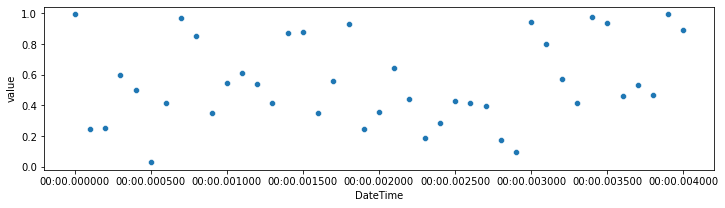

In [21]:
fix, ax = plt.subplots(figsize=(12, 3))
sns.scatterplot(x='DateTime', y='value', data=df)

# 軸目盛をμ秒単位で調整するためのlocaterオブジェクトを生成
locater = mdates.MicrosecondLocator(interval=500)
ax.xaxis.set_major_locator(locater)

In [22]:
# 時間のフィルタリング範囲を設定。最初の1000μ秒だけに絞る
start_time = datetime.datetime(year=2020, month=1, day=1, hour=0, minute=0, second=0, microsecond=0)
end_time = datetime.datetime(year=2020, month=1, day=1, hour=0, minute=0, second=0, microsecond=1000)

(18262.0, 18262.000000011572)

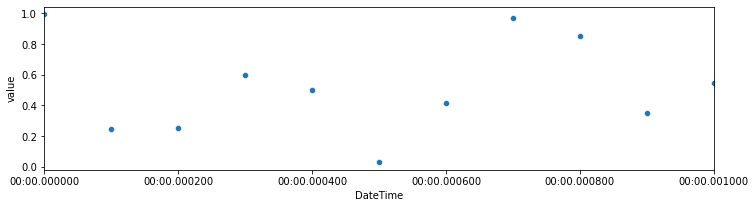

In [23]:
fix, ax = plt.subplots(figsize=(12, 3))
sns.scatterplot(x='DateTime', y='value', data=df)

# set_xlimに開始時刻と終了時刻をdatetime型で入れればOK
ax.set_xlim(start_time, end_time)
